In [1]:
# import things

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

2025-01-06 14:45:51.055234: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 14:45:51.090794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 14:45:51.090829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 14:45:51.091910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 14:45:51.097980: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
patch_size = 256
example_file_name = f'michongoddijn_231849_unet_model_it2_100epochs_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

2025-01-06 14:46:06.476451: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-06 14:46:06.476700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18136 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:e1:00.0, compute capability: 8.9


In [4]:
# Define any functions you need to process the mask e.g. Task 2
def preprocess_image_custom(image, legend=False):
    h, w = image.shape[:2]
    if legend:
        legend_width = 150
        legend_region = image[:, w - legend_width:]
        avg_intensity = np.mean(legend_region)
        if avg_intensity > 200:
            mask = np.ones((h, w), dtype=np.uint8) * 255
            mask[:, w - legend_width:] = 0
            image = cv2.bitwise_and(image, image, mask=mask)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(blurred)
    return enhanced

def detect_edges_custom(image):
    edges = cv2.Canny(image, 50, 150)
    _, binary = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    return cv2.addWeighted(edges, 0.6, binary, 0.4, 0)

def find_largest_square(image, edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_square = None
    max_area = 0
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        area = w * h
        aspect_ratio = w / h
        if 0.9 <= aspect_ratio <= 1.1 and area > max_area:
            max_area = area
            largest_square = (x, y, w, h)
    return largest_square

def crop_square(image, bounding_box, padding_ratio=0.04):
    x, y, w, h = bounding_box
    size = max(w, h)
    center_x, center_y = x + w // 2, y + h // 2
    padding = int(size * padding_ratio)
    size = size + 2 * padding
    x_start = max(center_x - size // 2, 0)
    y_start = max(center_y - size // 2, 0)
    x_end = min(center_x + size // 2, image.shape[1])
    y_end = min(center_y + size // 2, image.shape[0])
    return image[y_start:y_end, x_start:x_end]

In [5]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


In [6]:
# Find the petri dish
preprocessed_image = preprocess_image_custom(cv2.imread(task5_test_image_path))
edges = detect_edges_custom(preprocessed_image)
bounding_box = find_largest_square(preprocessed_image, edges)
petri_dish = crop_square(image, bounding_box)
print(petri_dish.shape)

(2826, 2826)


In [7]:
# Pad the petri dish
padding = 40
petri_dish_padded = cv2.copyMakeBorder(petri_dish, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=0)
print(petri_dish_padded.shape)

(2906, 2906)


2025-01-06 14:46:18.762263: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


5/5 [==============================] - 17s 2s/step


Text(0.5, 1.0, 'Prediction')

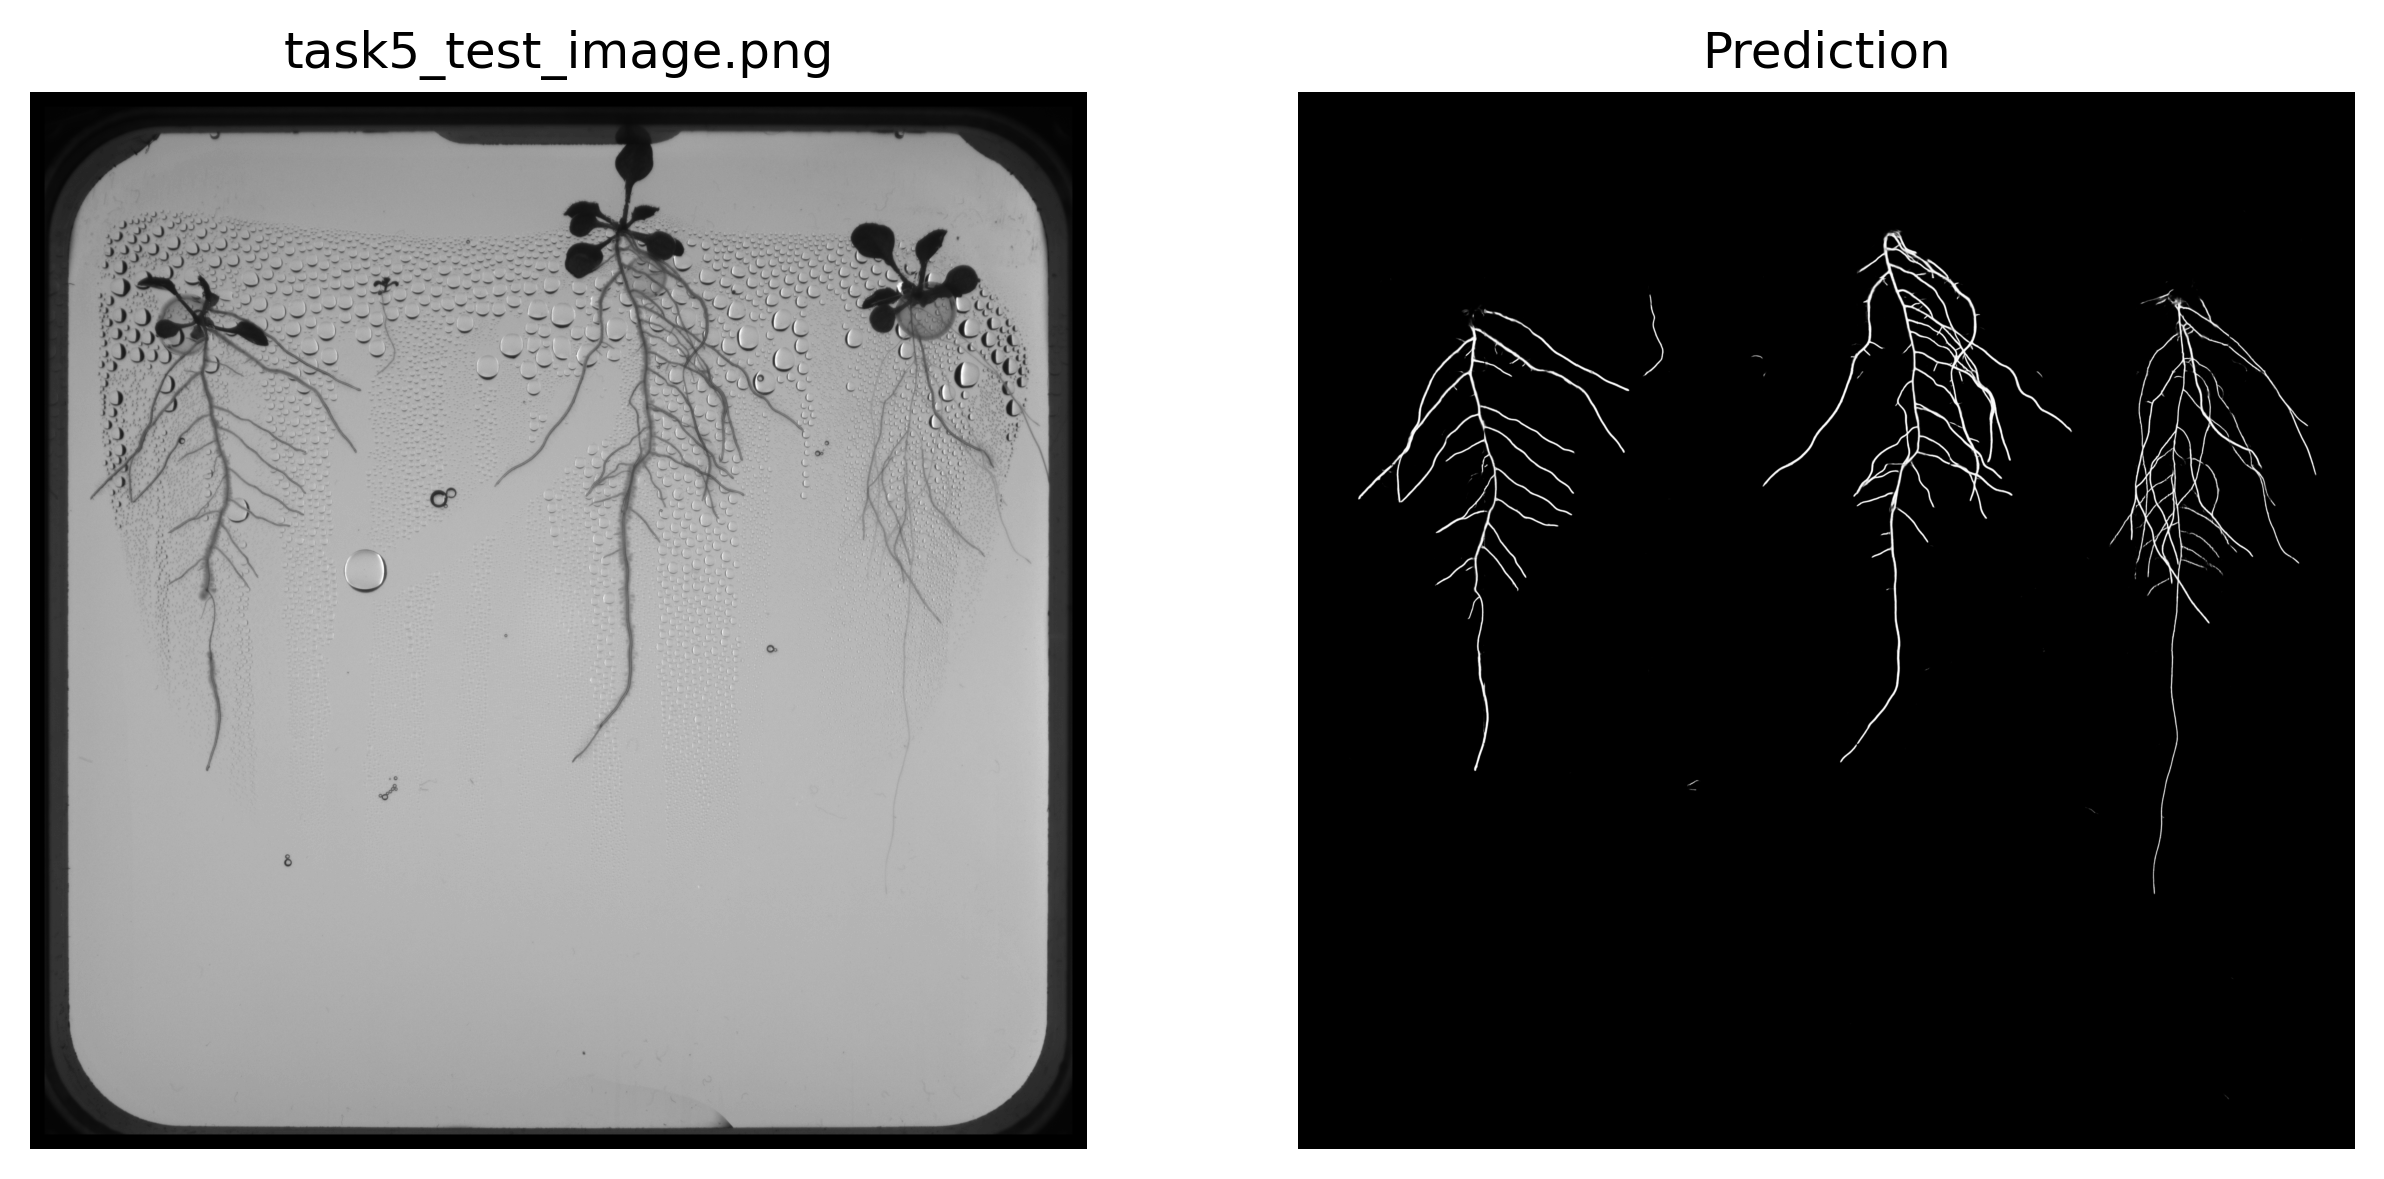

In [8]:
# PATCH
patches = []
coordinates = []  # To keep track of where each patch belongs
for i in range(0, petri_dish_padded.shape[0], patch_size):
    for j in range(0, petri_dish_padded.shape[1], patch_size):
        patch = petri_dish_padded[i:i + patch_size, j:j + patch_size]
        if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
            patches.append(patch)
        else:
            # Handle boundary patches
            temp_patch = np.zeros((patch_size, patch_size), dtype=np.float32)
            temp_patch[:patch.shape[0], :patch.shape[1]] = patch
            patches.append(temp_patch)
        coordinates.append((i, j))

patches = np.array(patches)
patches = patches[..., np.newaxis] / 255.0

# PREDICT
predictions = model.predict(patches)

# UNPATCH
predicted_mask = np.zeros_like(petri_dish_padded, dtype=np.float32)
for patch_idx, (i, j) in enumerate(coordinates):
    patch_prediction = predictions[patch_idx].squeeze()
    height, width = petri_dish_padded[i:i + patch_size, j:j + patch_size].shape
    predicted_mask[i:i + height, j:j + width] = patch_prediction[:height, :width]

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [9]:
predicted_mask.shape, image.shape

((2906, 2906), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [10]:
# Apply the corrections

# Reverse the padding
def remove_padding(image, padding):
    return image[padding:-padding, padding:-padding]

# Add the mask back to original size
def add_padding_to_original_size(cropped_image, original_shape, bounding_box, padding_ratio=0.04):
    x, y, w, h = bounding_box
    size = max(w, h)
    center_x, center_y = x + w // 2, y + h // 2
    padding = int(size * padding_ratio)
    size_with_padding = size + 2 * padding
    x_start = max(center_x - size_with_padding // 2, 0)
    y_start = max(center_y - size_with_padding // 2, 0)
    x_end = x_start + cropped_image.shape[1]
    y_end = y_start + cropped_image.shape[0]
    restored_image = np.zeros(original_shape, dtype=cropped_image.dtype)
    restored_image[y_start:y_end, x_start:x_end] = cropped_image
    return restored_image

# Correct the predicted mask
predicted_mask_unpadded = remove_padding(predicted_mask, padding)
predicted_mask_corrected = add_padding_to_original_size(predicted_mask_unpadded, image.shape, bounding_box)

# Convert the mask to binary
predicted_mask_corrected_binary = (predicted_mask_corrected > 0.5).astype(np.uint8) * 255

# Overlay mask in red
def overlay_mask_in_red(original_image, binary_mask):
    # Ensure the original image is in RGB format for correct color display
    if len(original_image.shape) == 2:  # Grayscale input
        original_image_colored = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
    else:
        original_image_colored = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Create a red overlay where the binary mask is non-zero
    red_overlay = original_image_colored.copy()
    red_overlay[binary_mask > 0] = [255, 0, 0]  # Solid red in RGB

    return red_overlay




overlay_image_red = overlay_mask_in_red(image, predicted_mask_corrected_binary)


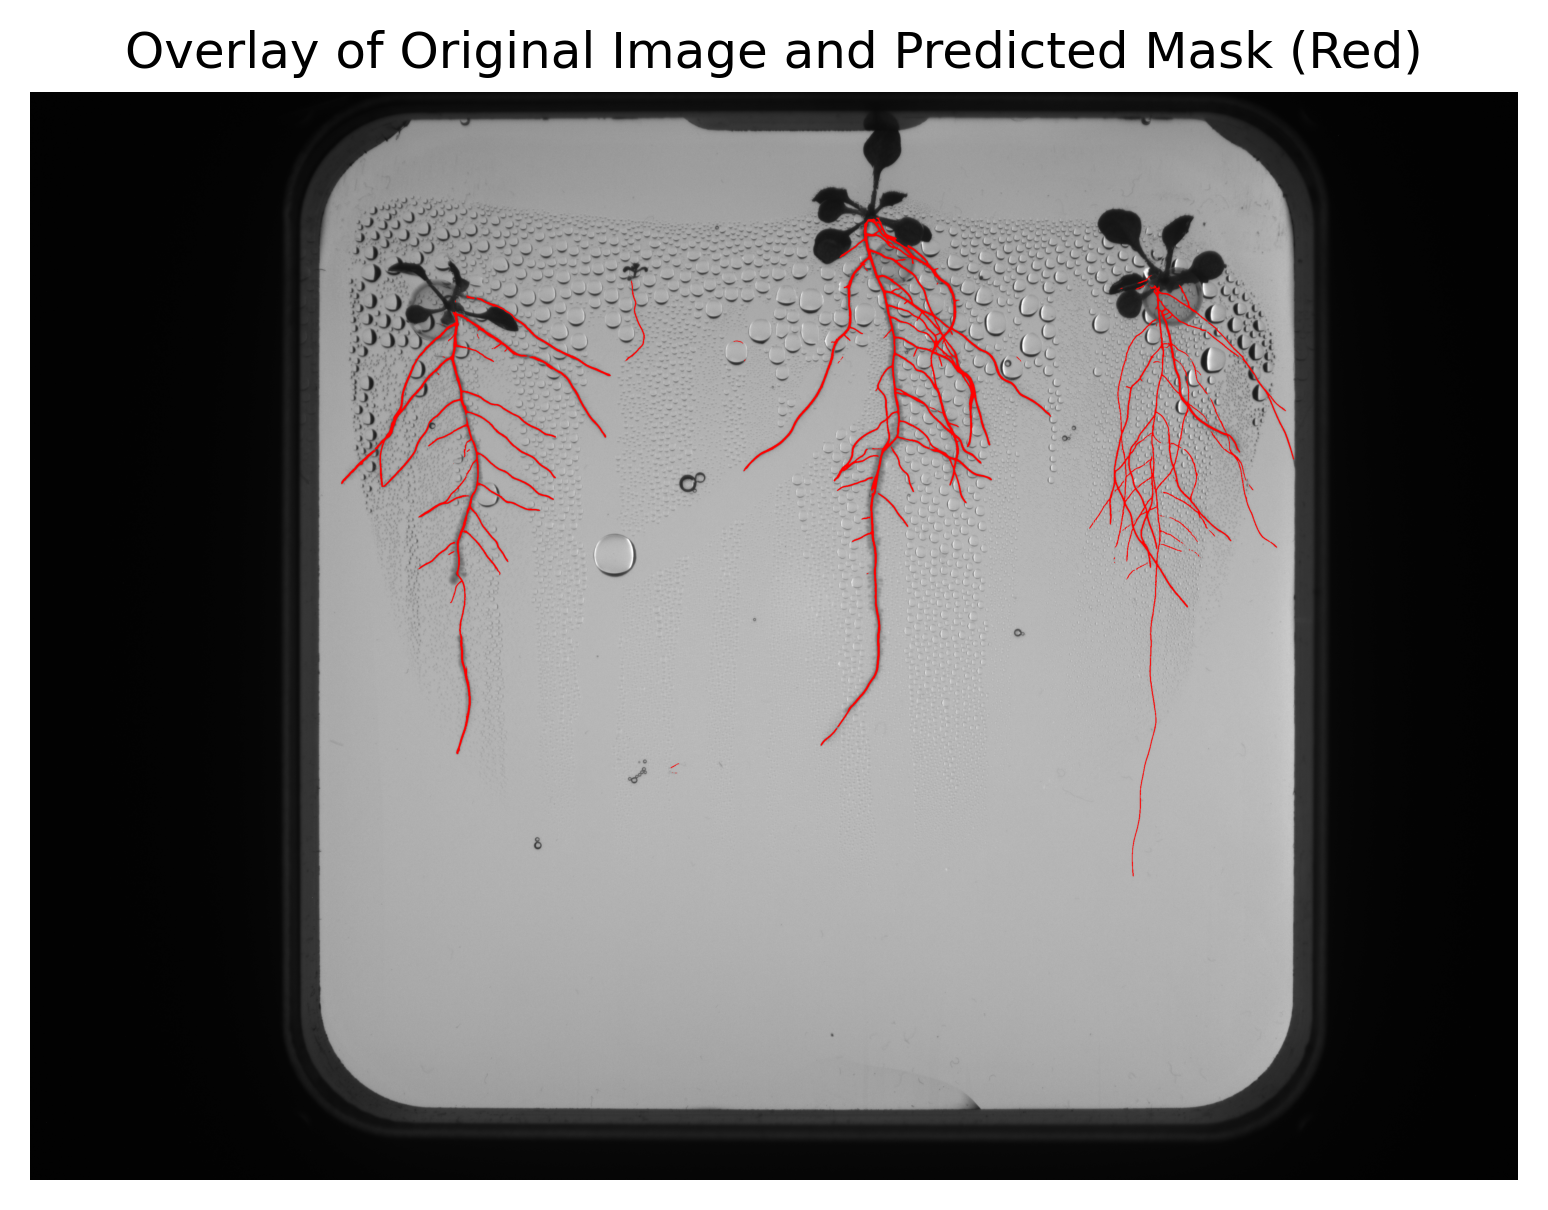

In [11]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.

# Save and display the result
plt.figure(dpi=300)
plt.imshow(overlay_image_red)
plt.title("Overlay of Original Image and Predicted Mask (Red)")
plt.axis("off")
plt.show()

In [12]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected * 255).astype(np.uint8)
assert(predicted_mask_corrected.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_michongoddijn_231849_it2_100epochs.png', mask_image)

True

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.